In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

In [167]:
import pandas as pd 
import matplotlib.pyplot as plt
from glob import glob
import os
import seaborn as sns

from parse_cesar1 import load_process_data
from pyprocessta.preprocess.resample import resample_regular
from pyprocessta.preprocess.clean import drop_duplicated_indices
from pyprocessta.preprocess.align import align_two_dfs
from pyprocessta.preprocess.detrend import detrend_stochastic, detrend_linear_deterministc
from pyprocessta.eda.statistics import check_stationarity
from pyprocessta.preprocess.smooth import z_score_filter

plt.style.use('science')

## Load data and simple plots

There are some parsing steps that are specific to this dataset wherefore they are not implemented in `pyprocessta`. 

In [3]:
FOLDER = '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data'

In [4]:
all_files = glob(os.path.join(FOLDER, "*xlsx"))

In [7]:
all_df_meas = []
all_df_gas = []
times = []

for file in all_files: 
    a, b, t = load_process_data(file)
    
    all_df_meas.append(a)
    all_df_gas.append(b)
    times.append(t)

valve NOT in columns
valve in columns
valve in columns
valve NOT in columns
valve NOT in columns
valve NOT in columns
valve NOT in columns
valve NOT in columns
valve NOT in columns
valve NOT in columns


In [8]:
df_gas = pd.concat(all_df_gas)
df_meas = pd.concat(all_df_meas)

In [44]:
GAS_COLUMNS = ['H2O', 'Carbon dioxide CO2', 'Ammonia NH3','2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2', 'Oxygen']

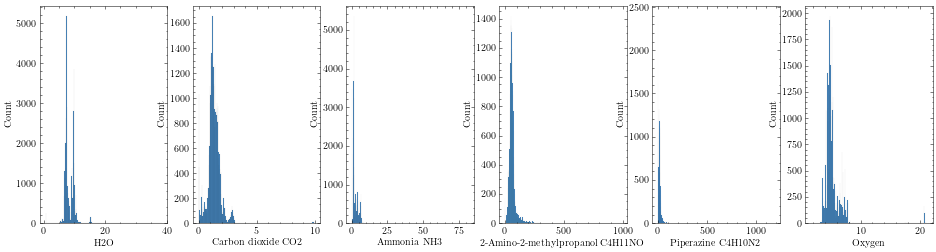

In [23]:
fig, ax = plt.subplots(1,6, figsize=(16,4))
for i, column in enumerate(GAS_COLUMNS): 
    if df_gas[column].dtype == 'float64':
        sns.histplot(df_gas[column], ax= ax[i])
        ax[i].set_xlabel(column)

In [91]:
MEAS_COLUMNS =[ 'PI-2', 'TI-2', 'FI-2', 'PI-3', 'TI-3', 'CO2-3', 'O2-3',
       'TI-32', 'TI-33', 'TI-34', 'TI-35', 'PI-4', 'TI-4', 'FI-4', 'CO2-4',
       'NH3-4', 'FI-11', 'TI-12', 'TI-13', 'FI-20', 'FI-211', 'TI-211', 'TI-8',
       'TI-9', 'TI-5', 'TI-7', 'TI-28', 'PI-28', 'PI-30', 'TI-30', 'FI-30',
       'FI-38', 'PI-38', 'FI-36', 'TI-36', 'Reboiler duty', 'FI-19', 'TI-19',
       'PI-1', 'TI-1', 'TI-35.1', 'FI-35', 'TI-39', 'FI-23', 'TI-22',
       'Level Desorber', 'Level Reboiler', 'TI-24', 'TI-25', 'FI-25', 'FI-16',
       'TI-16', 'FI-151', 'TI-151', 'TI-152', 'TI-212', 'FI-241', 'TI-241',
       'TI-242', 'valve-position-12', 'TI-1213']

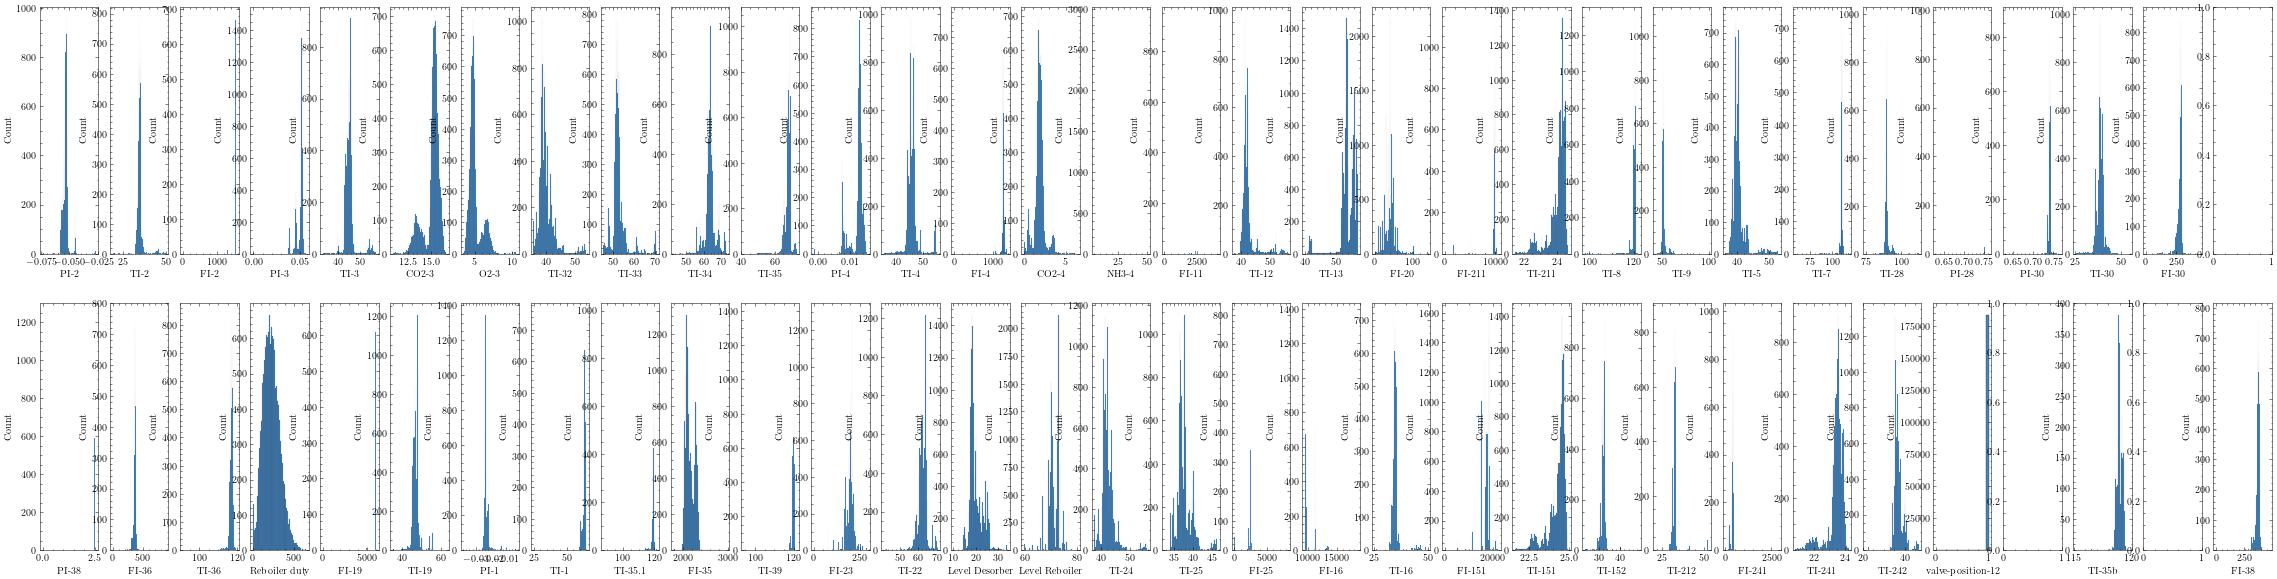

In [36]:
fig, ax = plt.subplots(2,32, figsize=(40,10))
for i, column in enumerate(MEAS_COLUMNS): 
    if df_meas[column].dtype == 'float64':
        if i < 31: 
            row = 0
            col = i
        else: 
            row = 1
            col = i - 32
        sns.histplot(df_meas[column], ax= ax[row][col])
        ax[row][col].set_xlabel(column)

## Resample and clean data

For the stationarity analysis and so on we assume that the data is on a regular grid.

### Measurement dataframe

In [62]:
df_meas_ss = df_meas[MEAS_COLUMNS].dropna()

In [75]:
df_meas_ss['TI-1213'] = df_meas_ss['TI-1213'].astype(float)

In [79]:
df_meas_ss = drop_duplicated_indices(df_meas_ss) # due to the concatenation there might be duplicated indices

In [80]:
df_meas_regular = resample_regular(df_meas_ss, '1min')

### Gas dataframe

In [82]:
df_gas_ss = df_gas[GAS_COLUMNS].dropna()

In [83]:
df_gas_ss = drop_duplicated_indices(df_gas_ss) # due to the concatenation there might be duplicated indices

In [84]:
df_gas_regular = resample_regular(df_gas_ss, '30s')

### Now, we can align them 

In [88]:
aligned_data =  align_two_dfs(df_gas_regular, df_meas_regular)

## Plot time series 

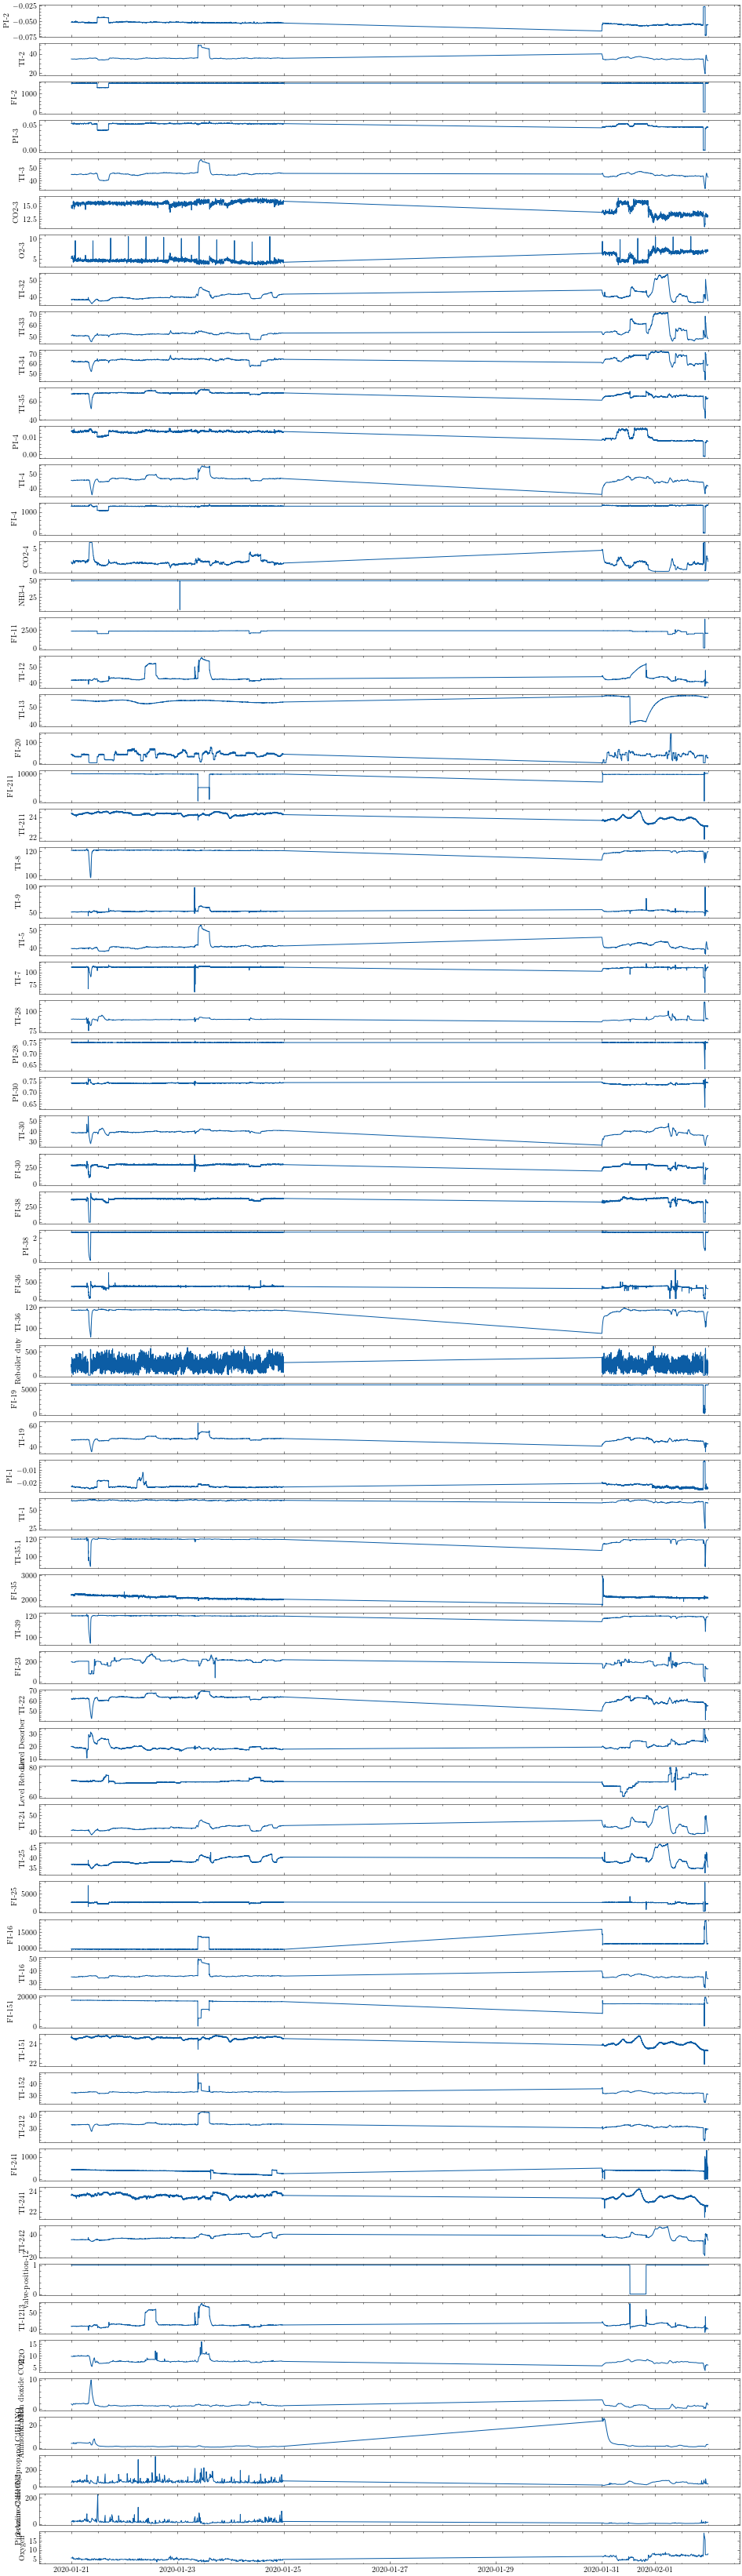

In [100]:
all_columns = MEAS_COLUMNS + GAS_COLUMNS

fig, ax = plt.subplots(len(all_columns), 1, figsize=(16,60), sharex='all')
for i, colunmn in enumerate(all_columns): 
    ax[i].plot(aligned_data[colunmn])
    ax[i].set_ylabel(colunmn)
    
fig.savefig('raw_timeseries.pdf', bbox_inches='tight')

## Perform statistical tests for stationarity

In [117]:
stationarity_test_results = []


for column in aligned_data: 
    r = {
        "name": column, 
        'raw': check_stationarity(aligned_data[colunmn])['stationary'], 
        'stochastic_detrend': check_stationarity(detrend_stochastic(aligned_data[colunmn]))['stationary'], 
        'deterministic_detrend': check_stationarity(detrend_linear_deterministc(aligned_data[colunmn]))['stationary']
    }
    
    stationarity_test_results.append(r)

/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-valu

In [118]:
results = pd.DataFrame(stationarity_test_results)

In [119]:
results.to_csv('detrending.csv', index=False)

In [120]:
results

,name,raw,stochastic_detrend,deterministic_detrend
0,H2O,False,True,False
1,Carbon dioxide CO2,False,True,False
2,Ammonia NH3,False,True,False
3,2-Amino-2-methylpropanol C4H11NO,False,True,False
4,Piperazine C4H10N2,False,True,False
...,...,...,...,...
62,FI-241,False,True,False
63,TI-241,False,True,False
64,TI-242,False,True,False
65,valve-position-12,False,True,False


It seems that I'll work on the derivative for this reason ...

## Detrend the data

## Smoothen the data

(-0.1, 0.1)

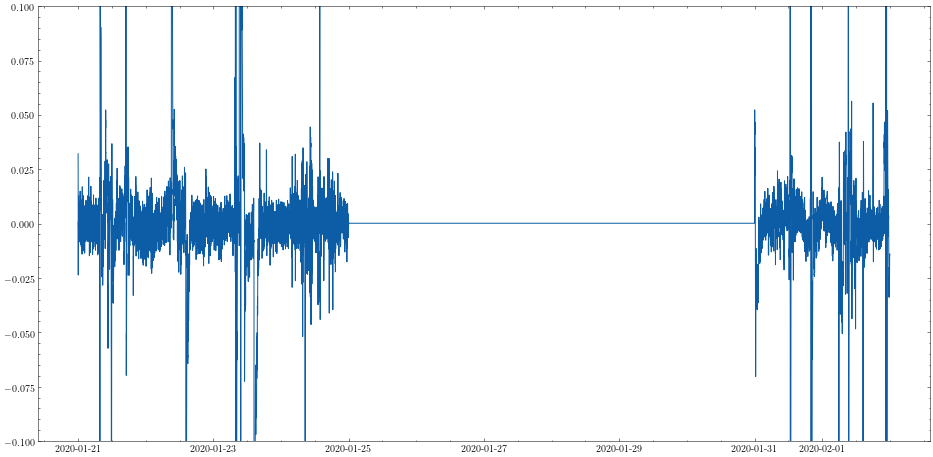

In [165]:
plt.figure(figsize=(16,8))
plt.plot(detrend_stochastic(aligned_data[column]).ewm(span = 10).mean())
plt.ylim(-0.1, 0.1)

## Despike the data

(-1.0, 1.0)

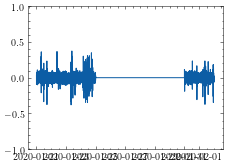

In [217]:
plt.plot(z_score_filter(detrend_stochastic(aligned_data[column]), window=60))
plt.ylim(-1,1)

In [194]:
len(aligned_data[column].index)

17280

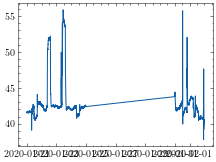

In [180]:
plt.plot(aligned_data[column])